In [1]:
    import jax
    
    # Эта команда должна показать ваше GPU устройство
    print(jax.devices())

[CudaDevice(id=0)]


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from jax.ops import segment_sum
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для JAX и NumPyro
numpyro.set_platform("cpu")
key = jax.random.PRNGKey(42)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [130]:
import jax
import jax.numpy as jnp
import numpy as np # Используем numpy для создания демо-данных

# --- 1. Ваши реальные данные (пример) ---

# Структура: { 'дата': { 'id_события': вектор_признаков } }
# Векторы признаков должны иметь одинаковую длину N_FEATURES.
N_FEATURES = 10 # Для примера

real_data_dict = {
    '2024-05-24': {
        'event_101': np.random.rand(N_FEATURES),
        'event_102': np.random.rand(N_FEATURES),
        'event_103': np.random.rand(N_FEATURES),
    },
    '2024-05-25': {
        'event_201': np.random.rand(N_FEATURES),
        'event_202': np.random.rand(N_FEATURES),
    },
    '2024-05-26': {
        'event_301': np.random.rand(N_FEATURES),
        'event_302': np.random.rand(N_FEATURES),
        'event_303': np.random.rand(N_FEATURES),
        'event_304': np.random.rand(N_FEATURES),
    }
}

# Источник целевых меток для каждого дня (замера).
# В реальной задаче эти значения должны быть известны.
y_targets_per_day = {
    '2024-05-24': 15.7,
    '2024-05-25': 12.1,
    '2024-05-26': 18.3,
}

# --- 2. Процесс преобразования ---

# Инициализируем списки для сбора данных
all_measurements_x = []
all_sample_indices = []
y_prior_samples_list = []

# Сортируем даты, чтобы обеспечить воспроизводимость порядка
sorted_dates = sorted(real_data_dict.keys())

# 3. Итерируемся по дням (замерам)
# enumerate дает нам sample_index (0, 1, 2, ...) для каждого дня
for sample_index, date in enumerate(sorted_dates):
    
    events_for_day = real_data_dict[date]
    
    # Пропускаем дни без событий
    if not events_for_day:
        continue
        
    # 4. Собираем данные для текущего дня
    
    # Получаем список всех векторов признаков за этот день
    # и сразу преобразуем в массив JAX
    X_i = jnp.array(list(events_for_day.values()))
    
    # k_i - количество измерений в этот день
    k_i = X_i.shape[0]
    
    # Добавляем признаки этого дня в общий список
    all_measurements_x.append(X_i)
    
    # Добавляем индекс этого дня (sample_index) k_i раз
    all_sample_indices.extend([sample_index] * k_i)
    
    # Находим целевую метку для этого дня и добавляем в список
    # Важно: если для какой-то даты может не быть метки, здесь нужна обработка ошибок
    target_y = y_targets_per_day[date]
    y_prior_samples_list.append(target_y)


# --- 5. Преобразуем списки в итоговые массивы JAX ---

# Объединяем все матрицы признаков X_i в одну большую матрицу
X_measurements = jnp.vstack(all_measurements_x)

# Преобразуем списки индексов и меток в массивы JAX
sample_idx = jnp.array(all_sample_indices)
Y_prior_samples = jnp.array(y_prior_samples_list)


# --- Параметры, полученные из данных ---
N_SAMPLES = len(y_prior_samples_list)
# N_FEATURES можно взять из первого же вектора
first_date = sorted_dates[0]
first_event_id = list(real_data_dict[first_date].keys())[0]
N_FEATURES_real = real_data_dict[first_date][first_event_id].shape[0]


# --- Печатаем результаты для проверки ---
print(f"Количество замеров (дней): {N_SAMPLES}")
print(f"Размерность вектора признаков: {N_FEATURES_real}")
print("-" * 30)
print(f"Итоговая форма матрицы признаков X_measurements: {X_measurements.shape}")
print(f"Итоговая длина вектора индексов sample_idx: {sample_idx.shape}")
print(f"Итоговая форма вектора меток Y_prior_samples: {Y_prior_samples.shape}")
print("-" * 30)
print("Пример содержимого:")
print("Y_prior_samples:", Y_prior_samples)
print("sample_idx:", sample_idx)

Количество замеров (дней): 3
Размерность вектора признаков: 10
------------------------------
Итоговая форма матрицы признаков X_measurements: (9, 10)
Итоговая длина вектора индексов sample_idx: (9,)
Итоговая форма вектора меток Y_prior_samples: (3,)
------------------------------
Пример содержимого:
Y_prior_samples: [15.7 12.1 18.3]
sample_idx: [0 0 0 1 1 2 2 2 2]


In [131]:
X_measurements.shape

(9, 10)

In [6]:


# --- Параметры симуляции ---
N_SAMPLES = 500  # Количество замеров
N_FEATURES = 35  # Размерность вектора признаков
MIN_MEASUREMENTS = 5  # Мин. кол-во измерений на замер
MAX_MEASUREMENTS = 15 # Макс. кол-во измерений на замер

# --- Генерируем "истинные" коэффициенты, которые модель должна будет найти ---
key = random.PRNGKey(0)
key, subkey = jax.random.split(key)
# Истинные коэффициенты для линейной зависимости
true_beta = jax.random.normal(subkey, shape=(N_FEATURES,)) * 2.5 
true_alpha = 10.0  # Истинное смещение (intercept)
true_sigma_prior = 1.5 # Истинный шум в Y_prior
true_nu = 7.0 # Истинные степени свободы (показывает умеренный шум)

# --- Создание данных в "длинном" формате ---
all_x = []
all_sample_indices = []
y_prior_samples = []

current_measurement_index = 0
for i in range(N_SAMPLES):
    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    
    # Случайное количество измерений для данного замера
    k_i = jax.random.randint(subkey1, shape=(), minval=MIN_MEASUREMENTS, maxval=MAX_MEASUREMENTS + 1).item()

    # Генерируем признаки для k_i измерений
    X_i = jax.random.normal(subkey2, shape=(k_i, N_FEATURES))
    
    # Рассчитываем "истинные" значения для каждого измерения
    y_ij_true = X_i @ true_beta + true_alpha
    
    # Агрегируем до уровня замера
    Y_i_true_aggregated = jnp.mean(y_ij_true)
    
    # Генерируем зашумленную априорную метку Y_prior из распределения Стьюдента
    Y_i_prior = dist.StudentT(df=true_nu, loc=Y_i_true_aggregated, scale=true_sigma_prior).sample(subkey3)
    
    # Добавляем данные в списки
    all_x.append(X_i)
    all_sample_indices.extend([i] * k_i)
    y_prior_samples.append(Y_i_prior)

# Собираем все в единые массивы
X_measurements = jnp.vstack(all_x)
sample_idx = jnp.array(all_sample_indices)
Y_prior_samples = jnp.array(y_prior_samples)

print(f"Итоговая форма матрицы признаков X_measurements: {X_measurements.shape}")
print(f"Итоговая длина вектора индексов sample_idx: {sample_idx.shape}")
print(f"Итоговая форма вектора меток Y_prior_samples: {Y_prior_samples.shape}")

Итоговая форма матрицы признаков X_measurements: (4965, 35)
Итоговая длина вектора индексов sample_idx: (4965,)
Итоговая форма вектора меток Y_prior_samples: (500,)


In [129]:
k_i

7

In [128]:
sample_idx[16]

Array(1, dtype=int32)

In [7]:
# Уникальные ID замеров (от 0 до 499)
unique_sample_ids = np.arange(N_SAMPLES)

# Разделяем ID замеров на обучающие и тестовые
train_ids, test_ids = train_test_split(unique_sample_ids, test_size=0.2, random_state=42)

# Создаем маски для фильтрации "длинных" таблиц
train_mask = np.isin(sample_idx, train_ids)
test_mask = np.isin(sample_idx, test_ids)

# --- Формируем обучающую выборку ---
X_train = X_measurements[train_mask]
y_train = Y_prior_samples[train_ids]
# Важно: нужно переиндексировать sample_idx для train, чтобы они шли от 0 до N_train-1
_, sample_idx_train = np.unique(sample_idx[train_mask], return_inverse=True)


# --- Формируем тестовую выборку ---
X_test = X_measurements[test_mask]
y_test = Y_prior_samples[test_ids]
# Аналогично переиндексируем для test
_, sample_idx_test = np.unique(sample_idx[test_mask], return_inverse=True)


# --- Масштабирование признаков (ОБЯЗАТЕЛЬНО) ---
# Обучаем скейлер ТОЛЬКО на обучающих данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Применяем тот же скейлер к тестовым данным
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмеры обучающей выборки:")
print(f"X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape}, sample_idx_train: {sample_idx_train.shape}")
print(f"\nРазмеры тестовой выборки:")
print(f"X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape}, sample_idx_test: {sample_idx_test.shape}")


Размеры обучающей выборки:
X_train_scaled: (3959, 35), y_train: (400,), sample_idx_train: (3959,)

Размеры тестовой выборки:
X_test_scaled: (1006, 35), y_test: (100,), sample_idx_test: (1006,)


In [8]:
def linear_hierarchical_model(
    X_measurements,      # Матрица признаков (Обучающая или Тестовая)
    sample_idx,          # Соответствующие индексы группировки
    Y_prior_samples=None # Целевые метки (только для обучения)
):
    """
    Иерархическая модель с ЛИНЕЙНЫМ ядром.
    """
    n_total_measurements, n_features = X_measurements.shape
    # +1, т.к. индексы от 0 до N-1
    n_samples = jnp.max(sample_idx) + 1 if sample_idx.size > 0 else 0


    # --- 1. Ядро модели: Байесовская Линейная Регрессия ---
    # Приор на смещение (intercept)
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    # Приоры на коэффициенты регрессии для каждого из 35 признаков
    beta = numpyro.sample("beta", dist.Normal(0, 2).expand([n_features]))

    # Forward pass для получения предсказаний на уровне измерений
    # y = X * beta + alpha
    output = X_measurements @ beta + alpha
    y_pred_measurements = numpyro.deterministic("y_pred_measurements", output)

    # --- 2. Агрегация предсказаний до уровня замера ---
    y_sum_per_sample = segment_sum(y_pred_measurements, sample_idx, num_segments=n_samples)
    
    counts_per_sample = segment_sum(jnp.ones_like(y_pred_measurements), sample_idx, num_segments=n_samples)
    counts_per_sample = jnp.maximum(counts_per_sample, 1) # Защита от деления на ноль
    
    Y_pred_aggregated = numpyro.deterministic(
        "Y_pred_aggregated", 
        y_sum_per_sample / counts_per_sample
    )

    # --- 3. Связь с наблюдаемыми данными (робастная) ---
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1)) # Приор на параметр робастности
    sigma_prior = numpyro.sample("sigma_prior", dist.HalfCauchy(5)) # Масштаб ошибки
    
    # plate используется для векторизации вычислений
    with numpyro.plate("samples_plate", n_samples):
        numpyro.sample(
            "Y_prior_obs",
            dist.StudentT(df=nu, loc=Y_pred_aggregated, scale=sigma_prior),
            obs=Y_prior_samples
        )

In [9]:
# --- Запуск MCMC ---
kernel = NUTS(linear_hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    key, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train, 
    Y_prior_samples=y_train
)

# Выводим сводку по апостериорным распределениям параметров
print("\n--- Результаты обучения модели (сводка по параметрам) ---")
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
segment_sum() `num_segments` argument.
The error occurred while tracing the function _body_fn at /usr/local/lib/python3.10/dist-packages/numpyro/infer/hmc_util.py:1003 for while_body. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f32[][39m = mul 0.5:f32[] b
    from line /usr/local/lib/python3.10/dist-packages/numpyro/infer/hmc_util.py:299 (<lambda>)

  operation a[35m:f32[][39m = mul 0.5:f32[] b
    from line /usr/local/lib/python3.10/dist-packages/numpyro/infer/hmc_util.py:299 (<lambda>)

  operation a[35m:f32[][39m = mul 0.5:f32[] b
    from line /usr/local/lib/python3.10/dist-packages/numpyro/infer/hmc_util.py:299 (<lambda>)

  operation a[35m:f32[][39m = mul 0.5:f32[] b
    from line /usr/local/lib/python3.10/dist-packages/numpyro/infer/hmc_util.py:299 (<lambda>)

  operation a[35m:i32[][39m = reduce_max[axes=(0,)] b
    from line /tmp/ipykernel_590/1770156565.py:11 (linear_hierarchical_model)

(Additional originating lines are not shown.)

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [74]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.ops import segment_sum 
from numpyro.infer import MCMC, NUTS

# ИСПРАВЛЕННАЯ МОДЕЛЬ
def linear_hierarchical_model(
    X_measurements,      # Матрица признаков (Обучающая или Тестовая)
    sample_idx,          # Соответствующие индексы группировки
    n_samples,           # <<< ДОБАВЛЕНО: Количество групп (сэмплов)
    Y_prior_samples=None # Целевые метки (только для обучения)
):
    """
    Иерархическая модель с ЛИНЕЙНЫМ ядром.
    """
    n_total_measurements, n_features = X_measurements.shape
    # <<< УДАЛЕНО: Строка ниже вычислялась внутри и вызывала ошибку
    # n_samples = jnp.max(sample_idx) + 1 if sample_idx.size > 0 else 0


    # --- 1. Ядро модели: Байесовская Линейная Регрессия ---
    # Приор на смещение (intercept)
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    # Приоры на коэффициенты регрессии для каждого из 35 признаков
    beta = numpyro.sample("beta", dist.Normal(0, 15).expand([n_features]))
    #beta = numpyro.sample("beta", dist.Normal(0, 2).expand([n_features]))

    # Forward pass для получения предсказаний на уровне измерений
    # y = X * beta + alpha
    output = X_measurements @ beta + alpha
    y_pred_measurements = numpyro.deterministic("y_pred_measurements", output)

    # --- 2. Агрегация предсказаний до уровня замера ---
    # Теперь n_samples - это конкретное число, и segment_sum работает корректно
    y_sum_per_sample = segment_sum(y_pred_measurements, sample_idx, num_segments=n_samples)
    
    counts_per_sample = segment_sum(jnp.ones_like(y_pred_measurements), sample_idx, num_segments=n_samples)
    counts_per_sample = jnp.maximum(counts_per_sample, 1) # Защита от деления на ноль
    
    Y_pred_aggregated = numpyro.deterministic(
        "Y_pred_aggregated", 
        y_sum_per_sample / counts_per_sample
    )
    
    #X_mean_per_sample = segment_sum(X_measurements, sample_idx) / counts_per_sample

    # Линейная модель для логарифма sigma
    #log_sigma_b = numpyro.sample("log_sigma_b", dist.Normal(0, 1).expand([n_features]))
    #log_sigma_a = numpyro.sample("log_sigma_a", dist.Normal(0, 1))
    
    # Предсказываем логарифм sigma для каждого замера
    #log_sigma_pred = X_mean_per_sample @ log_sigma_b + log_sigma_a
    #sigma_pred = numpyro.deterministic("sigma_pred", jnp.exp(log_sigma_pred))

    
    # --- 3. Связь с наблюдаемыми данными (робастная) ---
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1)) # Приор на параметр робастности
    sigma_prior = numpyro.sample("sigma_prior", dist.HalfCauchy(5)) # Масштаб ошибки
    
    # plate используется для векторизации вычислений
    # Здесь n_samples также используется для определения размера plate, что теперь тоже корректно
 
    with numpyro.plate("samples_plate", n_samples):
        numpyro.sample(
            "Y_prior_obs",
            dist.StudentT(df=nu, loc=Y_pred_aggregated, scale=sigma_prior),
            obs=Y_prior_samples
        )

In [75]:
# (Предполагается, что у вас есть данные X_train_scaled, sample_idx_train, y_train и ключ key)

# --- Вычисляем количество групп ЗАРАНЕЕ ---
n_samples_train = int(jnp.max(sample_idx_train)) + 1 if sample_idx_train.size > 0 else 0

# --- Запуск MCMC с новым аргументом ---
kernel = NUTS(linear_hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    key, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train, 
    n_samples=n_samples_train, # <<< ПЕРЕДАЕМ ВЫЧИСЛЕННОЕ ЗНАЧЕНИЕ
    Y_prior_samples=y_train
)

# Выводим сводку по апостериорным распределениям параметров
print("\n--- Результаты обучения модели (сводка по параметрам) ---")
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:18<00:00, 166.39it/s, 7 steps of size 4.88e-01. acc. prob=0.87]


--- Результаты обучения модели (сводка по параметрам) ---

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        alpha      9.82      0.31      9.82      9.34     10.32   3271.65      1.00
      beta[0]     -0.16      1.02     -0.18     -1.83      1.50   2907.51      1.00
      beta[1]     -0.32      0.96     -0.33     -1.92      1.25   2184.90      1.00
      beta[2]      0.01      1.05      0.02     -1.72      1.72   2260.89      1.00
      beta[3]     -0.31      0.94     -0.32     -1.99      1.12   2726.36      1.00
      beta[4]     -1.35      1.09     -1.35     -3.27      0.31   2679.28      1.00
      beta[5]      1.47      1.04      1.48     -0.24      3.15   2625.01      1.00
      beta[6]     -1.36      1.00     -1.35     -3.01      0.27   2492.89      1.00
      beta[7]      0.86      1.02      0.85     -0.85      2.52   3132.26      1.00
      beta[8]      1.28      0.96      1.28     -0.43      2.75   3167.08      1.00
      beta[9]   


--- Оценка на тренировочной выборке ---
Средняя абсолютная ошибка (MAE): 4.780


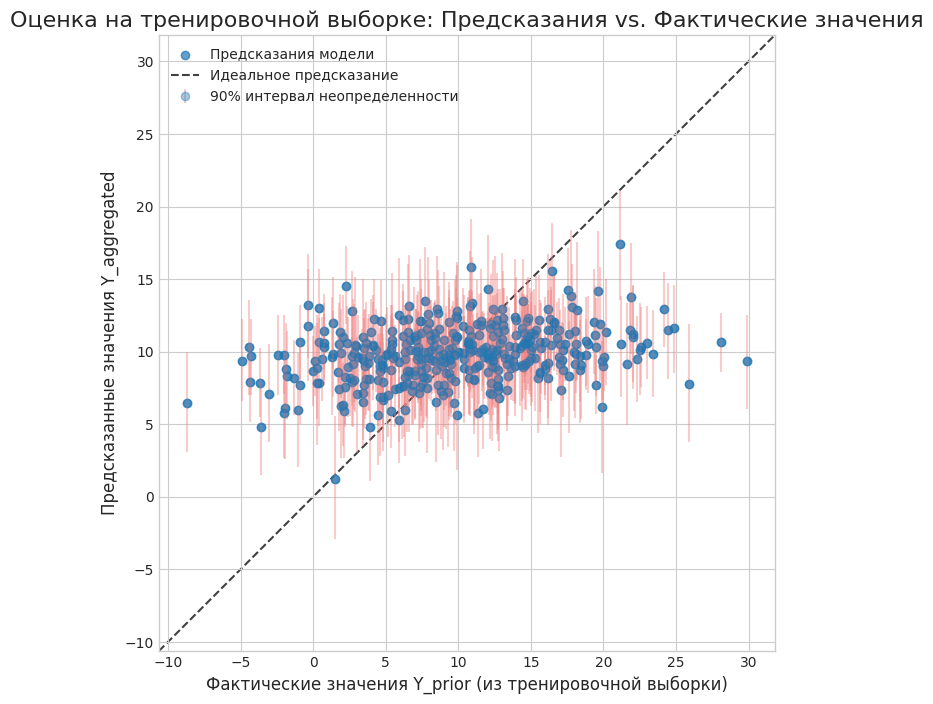

In [76]:
# --- Генерация предсказаний для тренировочной выборки ---
predictive = Predictive(linear_hierarchical_model, samples)
key, subkey = jax.random.split(key)

# --- ИСПРАВЛЕНИЕ НАЧИНАЕТСЯ ЗДЕСЬ ---

# Вычисляем недостающие параметры для тестового набора данных
n_samples_train = len(y_train) # или jnp.max(sample_idx_test) + 1
n_features_train = X_train_scaled.shape[1]

train_predictions = predictive(
    subkey, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train,
    n_samples=n_samples_train,      # <--- Добавляем n_samples
    # <--- Добавляем n_features
)

# --- ИСПРАВЛЕНИЕ ЗАКАНЧИВАЕТСЯ ЗДЕСЬ ---

# Извлекаем предсказанные агрегированные значения

# Извлекаем предсказанные агрегированные значения
y_pred_mean = jnp.mean(train_predictions['Y_pred_aggregated'], axis=0)
y_pred_std = jnp.std(train_predictions['Y_pred_aggregated'], axis=0)

# Рассчитываем 90% интервал правдоподобия
ci_lower = jnp.percentile(train_predictions['Y_pred_aggregated'], 5, axis=0)
ci_upper = jnp.percentile(train_predictions['Y_pred_aggregated'], 95, axis=0)


# --- Оценка качества ---
mae = jnp.mean(jnp.abs(y_pred_mean - y_train))
print(f"\n--- Оценка на тренировочной выборке ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")


# --- Визуализация результатов ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Диаграмма рассеяния: предсказанные vs фактические значения
ax.scatter(y_train, y_pred_mean, alpha=0.7, label='Предсказания модели')

# Добавляем интервалы неопределенности для каждого предсказания
ax.errorbar(y_train, y_pred_mean, yerr=[y_pred_mean - ci_lower, ci_upper - y_pred_mean], 
            fmt='o', ecolor='lightcoral', capsize=0, alpha=0.4, label='90% интервал неопределенности')

# Идеальная линия y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Идеальное предсказание')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Оценка на тренировочной выборке: Предсказания vs. Фактические значения', fontsize=16)
ax.set_xlabel('Фактические значения Y_prior (из тренировочной выборки)', fontsize=12)
ax.set_ylabel('Предсказанные значения Y_aggregated', fontsize=12)
ax.legend()
plt.show()

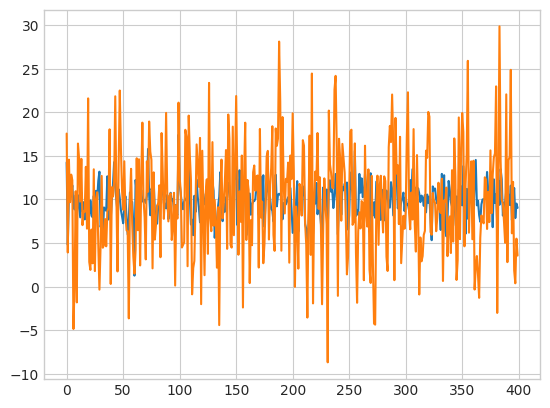

In [77]:
plt.plot(y_pred_mean)
plt.plot(y_train)

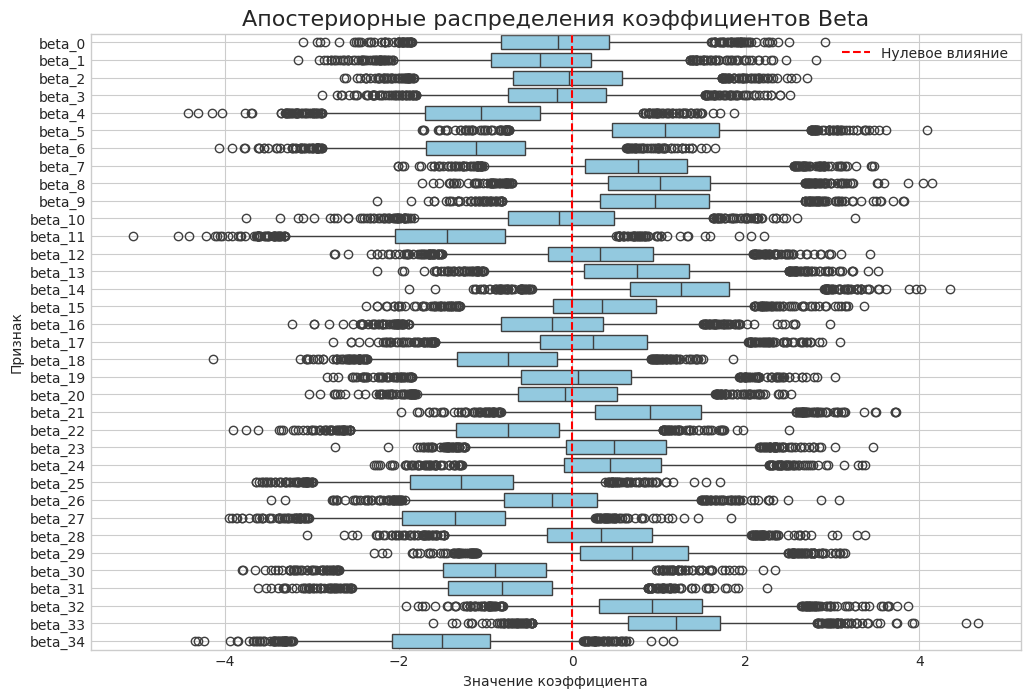

In [19]:
# Код после mcmc.run(...)
samples = mcmc.get_samples()
beta_samples = samples['beta'] # Получаем сэмплы для коэффициентов beta

# Создаем DataFrame для удобства визуализации
df_beta = pd.DataFrame(beta_samples, columns=[f'beta_{i}' for i in range(N_FEATURES)])

# Визуализация
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_beta, orient='h', whis=[2.5, 97.5], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', label='Нулевое влияние')
plt.title('Апостериорные распределения коэффициентов Beta', fontsize=16)
plt.xlabel('Значение коэффициента')
plt.ylabel('Признак')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# --- ИЗМЕНЕННАЯ ВЕРСИЯ МОДЕЛИ ---

def robust_mixture_model(
    X_measurements,
    sample_idx,
    n_samples,  # <-- НОВЫЙ АРГУМЕНТ
    Y_prior_samples=None
):
    """
    Иерархическая модель смеси для обработки экстремальных выбросов.
    """
    # Удаляем вычисление n_samples изнутри модели
    # n_samples = jnp.max(sample_idx) + 1 if sample_idx.size > 0 else 0
    n_total_measurements, n_features = X_measurements.shape
    
    # ... остальной код модели остается без изменений ...
    
    # --- 1. Ядро модели (линейное или БНС, как и раньше) ---
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    beta = numpyro.sample("beta", dist.Normal(0, 2).expand([n_features]))
    
    output = X_measurements @ beta + alpha
    y_pred_measurements = numpyro.deterministic("y_pred_measurements", output)

    # Теперь segment_sum получает конкретное значение n_samples
    y_sum_per_sample = segment_sum(y_pred_measurements, sample_idx, num_segments=n_samples)
    counts_per_sample = segment_sum(jnp.ones_like(y_pred_measurements), sample_idx, num_segments=n_samples)
    counts_per_sample = jnp.maximum(counts_per_sample, 1)
    
    Y_pred_aggregated = numpyro.deterministic(
        "Y_pred_aggregated", 
        y_sum_per_sample / counts_per_sample
    )

    # --- 2. Компоненты смеси ---
    
    # "Сигнальный" компонент
    nu_signal = numpyro.sample("nu_signal", dist.Gamma(2, 0.1))
    sigma_signal = numpyro.sample("sigma_signal", dist.HalfCauchy(2))
    dist_signal = dist.StudentT(df=nu_signal, loc=Y_pred_aggregated, scale=sigma_signal)
    
    # "Шумовой" (выбросовый) компонент
    y_mean = jnp.mean(Y_prior_samples) if Y_prior_samples is not None else 0
    y_std = jnp.std(Y_prior_samples) if Y_prior_samples is not None else 1
    dist_outlier = dist.Normal(y_mean, y_std * 5) 

    # --- 3. Параметры и логика смеси ---
    
    pi_outlier = numpyro.sample("pi_outlier", dist.Beta(1, 1))
    mix_probs = jnp.array([1 - pi_outlier, pi_outlier])
    mixture_dist = dist.Mixture(dist.Categorical(probs=mix_probs), [dist_signal, dist_outlier])

    # --- 4. Связь с наблюдаемыми данными ---
    with numpyro.plate("samples_plate", n_samples):
        numpyro.sample("Y_prior_obs", mixture_dist, obs=Y_prior_samples)

In [34]:
n_samples_train = int(jnp.max(sample_idx_train)) + 1 if sample_idx_train.size > 0 else 0

# --- Запуск MCMC с новым аргументом ---
kernel = NUTS(robust_mixture_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    key, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train, 
    n_samples=n_samples_train, # <<< ПЕРЕДАЕМ ВЫЧИСЛЕННОЕ ЗНАЧЕНИЕ
    Y_prior_samples=y_train
)

# Выводим сводку по апостериорным распределениям параметров
print("\n--- Результаты обучения модели (сводка по параметрам) ---")
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:21<00:00, 138.45it/s, 7 steps of size 4.29e-01. acc. prob=0.89] 



--- Результаты обучения модели (сводка по параметрам) ---

                    mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha      9.82      0.31      9.81      9.33     10.33   2421.29      1.00
       beta[0]     -0.16      0.90     -0.18     -1.64      1.31   2942.61      1.00
       beta[1]     -0.35      0.86     -0.35     -1.87      0.91   1930.41      1.00
       beta[2]     -0.08      0.88     -0.07     -1.52      1.32   2140.65      1.00
       beta[3]     -0.17      0.82     -0.19     -1.47      1.18   2155.28      1.00
       beta[4]     -1.04      0.94     -1.05     -2.49      0.61   2136.10      1.00
       beta[5]      1.02      0.89      1.05     -0.54      2.41   2002.17      1.00
       beta[6]     -1.14      0.89     -1.14     -2.75      0.24   1927.04      1.00
       beta[7]      0.74      0.88      0.72     -0.61      2.25   2582.89      1.00
       beta[8]      1.00      0.84      0.98     -0.30      2.47   2822.69      1.00
     

In [41]:
X_train_scaled.shape

(3959, 35)

In [ ]:
"y_pred_measurements"

In [68]:
y_pred_mean = jnp.mean(test_predictions["y_pred_measurements"], axis=0)

In [71]:
y_pred_mean.shape

(1006,)


--- Оценка на тестовой выборке ---
Средняя абсолютная ошибка (MAE): 5.305


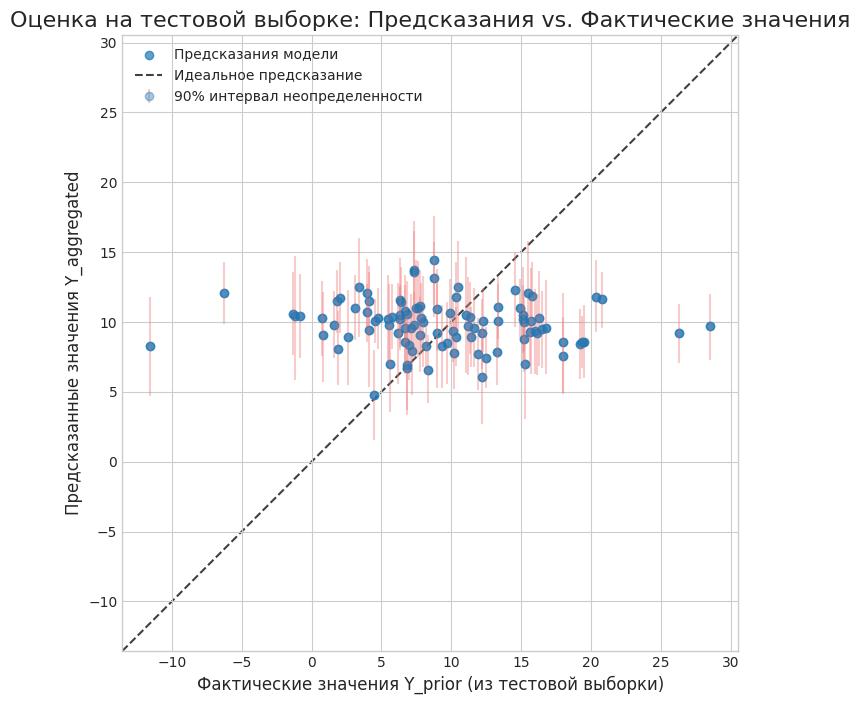

In [46]:
# ... После обучения модели mcmc.run(...) и получения сэмплов ...
samples = mcmc.get_samples()
posterior_predictive = Predictive(robust_mixture_model, samples)
# Вычисляем недостающие параметры для тестового набора данных
n_samples_test = len(y_test) # или jnp.max(sample_idx_test) + 1
n_features_test = X_test_scaled.shape[1]

test_predictions = posterior_predictive(
    subkey, 
    X_measurements=X_test_scaled, 
    sample_idx=sample_idx_test,
    n_samples=n_samples_test,      # <--- Добавляем n_samples
    # <--- Добавляем n_features
)
# --- ИСПРАВЛЕНИЕ ЗАКАНЧИВАЕТСЯ ЗДЕСЬ ---

# Извлекаем предсказанные агрегированные значения

# Извлекаем предсказанные агрегированные значения
y_pred_mean = jnp.mean(test_predictions['Y_pred_aggregated'], axis=0)
y_pred_std = jnp.std(test_predictions['Y_pred_aggregated'], axis=0)

# Рассчитываем 90% интервал правдоподобия
ci_lower = jnp.percentile(test_predictions['Y_pred_aggregated'], 5, axis=0)
ci_upper = jnp.percentile(test_predictions['Y_pred_aggregated'], 95, axis=0)


# --- Оценка качества ---
mae = jnp.mean(jnp.abs(y_pred_mean - y_test))
print(f"\n--- Оценка на тестовой выборке ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")


# --- Визуализация результатов ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Диаграмма рассеяния: предсказанные vs фактические значения
ax.scatter(y_test, y_pred_mean, alpha=0.7, label='Предсказания модели')

# Добавляем интервалы неопределенности для каждого предсказания
ax.errorbar(y_test, y_pred_mean, yerr=[y_pred_mean - ci_lower, ci_upper - y_pred_mean], 
            fmt='o', ecolor='lightcoral', capsize=0, alpha=0.4, label='90% интервал неопределенности')

# Идеальная линия y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Идеальное предсказание')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Оценка на тестовой выборке: Предсказания vs. Фактические значения', fontsize=16)
ax.set_xlabel('Фактические значения Y_prior (из тестовой выборки)', fontsize=12)
ax.set_ylabel('Предсказанные значения Y_aggregated', fontsize=12)
ax.legend()
plt.show()

In [50]:
test_predictions['Y_pred_aggregated'].shape

(2000, 100)

In [59]:
samples = mcmc.get_samples()
posterior_predictive = Predictive(robust_mixture_model, samples)
# Убедимся, что Y_prior_samples тот же, что использовался для предсказаний
predictions = posterior_predictive(key, X_test_scaled, sample_idx_test,n_samples_test, Y_prior_samples=y_test)
y_pred_robust_mean = predictions['Y_pred_aggregated'].mean(axis=0)
# Получим ключевые размерности для ясности
num_mcmc_samples = samples['pi_outlier'].shape[0]
num_data_points = y_test.shape[0]

# --- ИСПРАВЛЕНИЕ НАЧИНАЕТСЯ ЗДЕСЬ ---

# Убедимся, что данные консистентны (опциональная проверка)
assert predictions['Y_pred_aggregated'].shape[1] == num_data_points, \
    f"Несоответствие размерностей: {predictions['Y_pred_aggregated'].shape[1]} предсказаний и {num_data_points} наблюдений Y"

In [67]:
samples

(100,)

In [52]:
samples['nu_signal'][:, None].shape

(2000, 1)

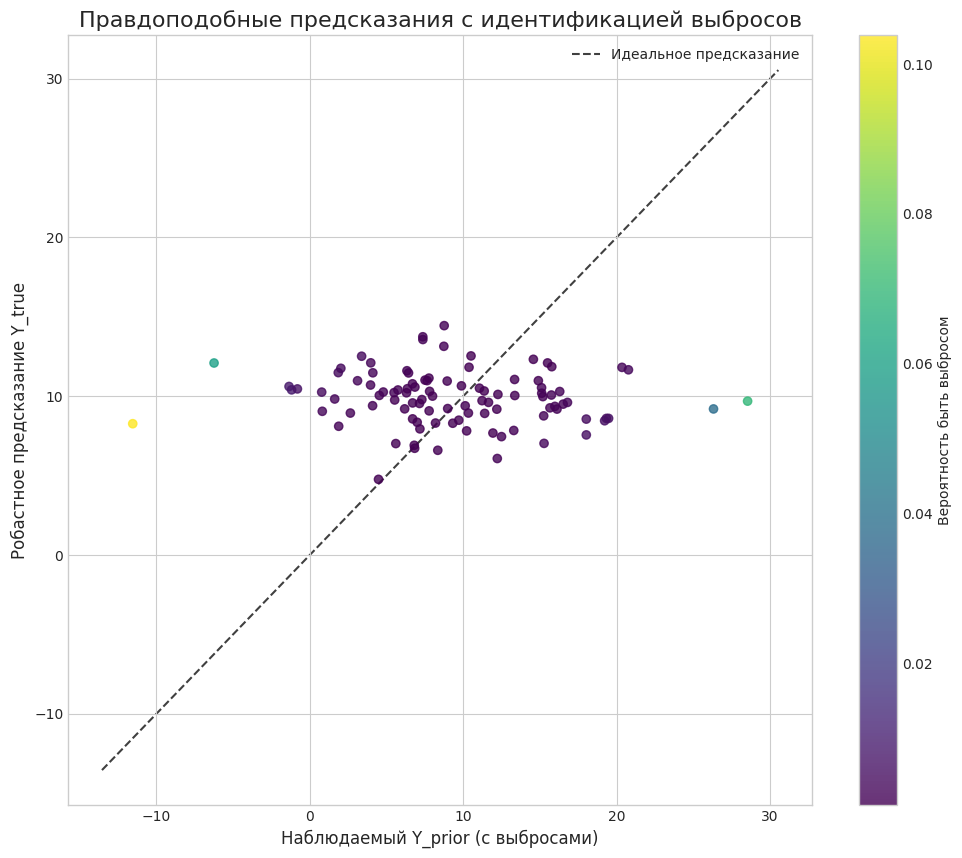

In [61]:
# 2. Вычисляем вероятность быть выбросом для каждой точки
# Формула основана на теореме Байеса: P(outlier|data) ∝ P(data|outlier) * P(outlier)
log_prob_signal = dist.StudentT(
    df=samples['nu_signal'][:, None], 
    loc=test_predictions['Y_pred_aggregated'], 
    scale=samples['sigma_signal'][:, None]
).log_prob(y_test)

log_prob_outlier = dist.Normal(
    y_test.mean(), y_test.std() * 5
).log_prob(y_test)

# Применяем веса смеси
numerator = jnp.exp(log_prob_outlier) * samples['pi_outlier'][:, None]
denominator = numerator + jnp.exp(log_prob_signal) * (1 - samples['pi_outlier'][:, None])

# Средняя вероятность быть выбросом для каждой точки
outlier_prob = (numerator / denominator).mean(axis=0)


# 3. Строим правдоподобный график
plt.figure(figsize=(12, 10))

# Используем цвет для кодирования вероятности выброса
scatter = plt.scatter(
    y_test, 
    y_pred_robust_mean, 
    c=outlier_prob, 
    cmap='viridis', # 'viridis' - от синего (не выброс) до желтого (выброс)
    alpha=0.8
)

# Идеальная линия
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()]),
]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Идеальное предсказание')

plt.colorbar(scatter, label='Вероятность быть выбросом')
plt.title('Правдоподобные предсказания с идентификацией выбросов', fontsize=16)
plt.xlabel('Наблюдаемый Y_prior (с выбросами)', fontsize=12)
plt.ylabel('Робастное предсказание Y_true', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


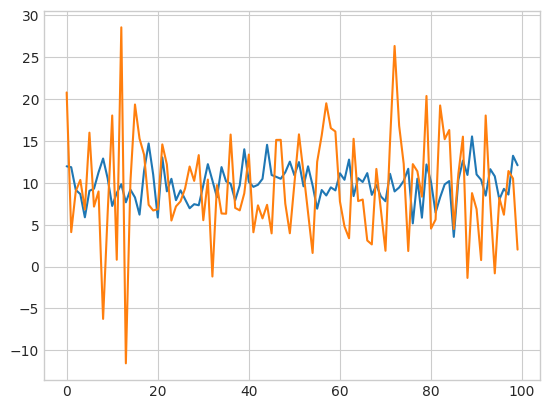

In [44]:
plt.plot(y_pred_mean)
plt.plot(y_test)

In [62]:
y_preds_per_measurement = samples["y_pred_measurements"]

In [64]:
y_preds_per_measurement.shape

(2000, 3959)

In [66]:
mean_predictions = jnp.mean(y_preds_per_measurement, axis=0)
mean_predictions.shape

(3959,)

In [120]:
# Ваша исходная модель (для сравнения)
# alpha = numpyro.sample("alpha", dist.Normal(0, 10))
# output = X_measurements @ beta + alpha

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax.ops import segment_sum
# lax больше не нужен для этой части
# from jax import lax 

def random_intercept_model(
    X_measurements,
    sample_idx,
    n_samples,  # <--- ШАГ 1: Добавляем как аргумент
    Y_prior_samples=None
):
    # Вычисление n_samples теперь происходит снаружи.
    # Мы просто используем переданное значение.
    
    n_total_measurements, n_features = X_measurements.shape
    
    # --- 1. Параметры модели ---
    alpha_global = numpyro.sample("alpha_global", dist.Normal(0.0, 10.0))
    sigma_alpha = numpyro.sample("sigma_alpha", dist.HalfCauchy(5.0))
    
    # В plate теперь используется СТАТИЧЕСКОЕ значение n_samples
    with numpyro.plate("samples_plate_alpha", n_samples):
        alpha_offset = numpyro.sample("alpha_offset", dist.Normal(0.0, 10.0))
    
    alpha_per_sample = numpyro.deterministic("alpha_per_sample", alpha_global + alpha_offset * sigma_alpha)
    
    beta = numpyro.sample("beta", dist.Normal(0, 45).expand([n_features]))

    alpha_per_measurement = alpha_per_sample[sample_idx]
    
    output = X_measurements @ beta + alpha_per_measurement
    y_pred_measurements = numpyro.deterministic("y_pred_measurements", output)
    
    # --- 2. Агрегация и правдоподобие ---
    y_sum_per_sample = segment_sum(y_pred_measurements, sample_idx, num_segments=n_samples)
    counts_per_sample = segment_sum(jnp.ones_like(y_pred_measurements), sample_idx, num_segments=n_samples)
    counts_per_sample = jnp.maximum(counts_per_sample, 1)
    Y_pred_aggregated = numpyro.deterministic("Y_pred_aggregated", y_sum_per_sample / counts_per_sample)
    nu = numpyro.sample("nu", dist.Exponential(0.1))
    #nu = numpyro.sample("nu", dist.Gamma(2, 0.1))
    sigma_prior = numpyro.sample("sigma_prior", dist.HalfCauchy(15))
    
    # Здесь plate тоже использует статический n_samples
    with numpyro.plate("samples_plate_obs", n_samples):
        numpyro.sample(
            "Y_prior_obs",
            dist.StudentT(df=nu, loc=Y_pred_aggregated, scale=sigma_prior),
            obs=Y_prior_samples
        )

In [121]:
n_samples_train = int(jnp.max(sample_idx_train)) + 1 if sample_idx_train.size > 0 else 0

# --- Запуск MCMC с новым аргументом ---
kernel = NUTS(random_intercept_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    key, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train, 
    n_samples=n_samples_train, # <<< ПЕРЕДАЕМ ВЫЧИСЛЕННОЕ ЗНАЧЕНИЕ
    Y_prior_samples=y_train
)

# Выводим сводку по апостериорным распределениям параметров
print("\n--- Результаты обучения модели (сводка по параметрам) ---")
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:54<00:00, 54.87it/s, 63 steps of size 7.04e-02. acc. prob=0.50]  



--- Результаты обучения модели (сводка по параметрам) ---

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha_global      9.73      0.29      9.66      9.38     10.27     21.41      1.07
  alpha_offset[0]      2.43      7.08      1.56     -8.37     14.37     98.62      1.00
  alpha_offset[1]     -3.15      7.39     -4.29    -15.53      8.94     19.63      1.08
  alpha_offset[2]      4.54      7.07      4.87     -7.15     15.22    103.60      1.04
  alpha_offset[3]      0.50      6.85      0.23    -10.40     11.39     86.57      1.01
  alpha_offset[4]      3.92      7.61      4.26    -11.48     13.95     57.07      1.10
  alpha_offset[5]      1.21      6.69      1.60     -9.85     12.72    199.10      1.01
  alpha_offset[6]    -11.97      8.77    -12.75    -25.69      3.13     61.59      1.07
  alpha_offset[7]    -12.13      9.82    -13.36    -25.96      3.56      6.74      1.40
  alpha_offset[8]      0.77      7.49      1.07    -11.19   


--- Оценка на тренировочной выборке ---
Средняя абсолютная ошибка (MAE): 2.589


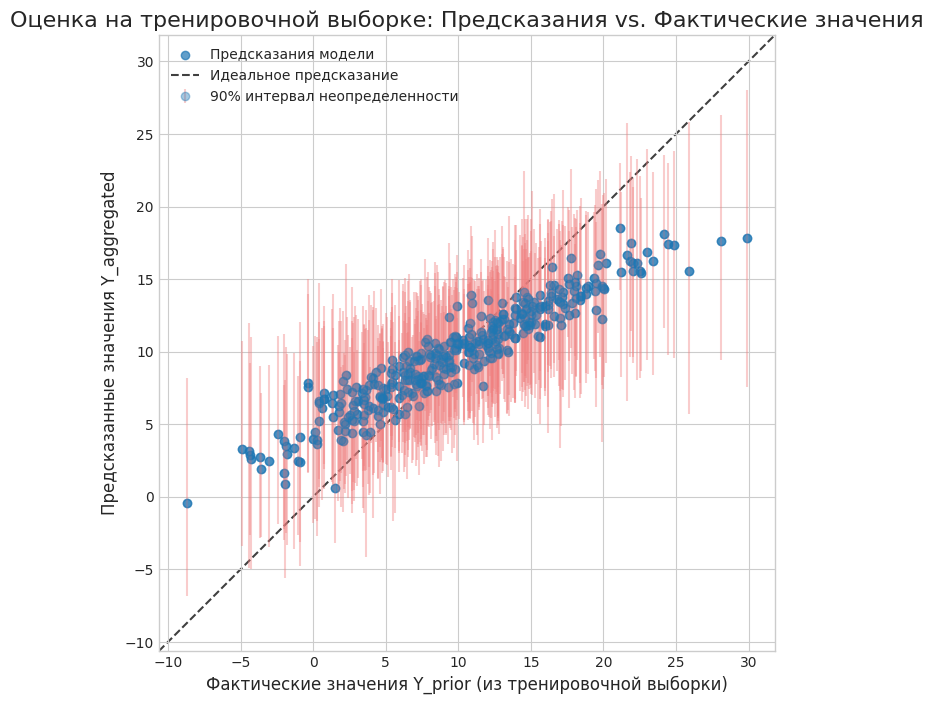

In [122]:
# --- Генерация предсказаний для тренировочной выборки ---
predictive = Predictive(random_intercept_model, samples)
key, subkey = jax.random.split(key)

# --- ИСПРАВЛЕНИЕ НАЧИНАЕТСЯ ЗДЕСЬ ---

# Вычисляем недостающие параметры для тестового набора данных
n_samples_train = len(y_train) # или jnp.max(sample_idx_test) + 1
n_features_train = X_train_scaled.shape[1]

train_predictions = predictive(
    subkey, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train,
    n_samples=n_samples_train,      # <--- Добавляем n_samples
    # <--- Добавляем n_features
)

# --- ИСПРАВЛЕНИЕ ЗАКАНЧИВАЕТСЯ ЗДЕСЬ ---

# Извлекаем предсказанные агрегированные значения

# Извлекаем предсказанные агрегированные значения
y_pred_mean = jnp.mean(train_predictions['Y_pred_aggregated'], axis=0)
y_pred_std = jnp.std(train_predictions['Y_pred_aggregated'], axis=0)

# Рассчитываем 90% интервал правдоподобия
ci_lower = jnp.percentile(train_predictions['Y_pred_aggregated'], 5, axis=0)
ci_upper = jnp.percentile(train_predictions['Y_pred_aggregated'], 95, axis=0)


# --- Оценка качества ---
mae = jnp.mean(jnp.abs(y_pred_mean - y_train))
print(f"\n--- Оценка на тренировочной выборке ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")


# --- Визуализация результатов ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Диаграмма рассеяния: предсказанные vs фактические значения
ax.scatter(y_train, y_pred_mean, alpha=0.7, label='Предсказания модели')

# Добавляем интервалы неопределенности для каждого предсказания
ax.errorbar(y_train, y_pred_mean, yerr=[y_pred_mean - ci_lower, ci_upper - y_pred_mean], 
            fmt='o', ecolor='lightcoral', capsize=0, alpha=0.4, label='90% интервал неопределенности')

# Идеальная линия y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Идеальное предсказание')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Оценка на тренировочной выборке: Предсказания vs. Фактические значения', fontsize=16)
ax.set_xlabel('Фактические значения Y_prior (из тренировочной выборки)', fontsize=12)
ax.set_ylabel('Предсказанные значения Y_aggregated', fontsize=12)
ax.legend()
plt.show()

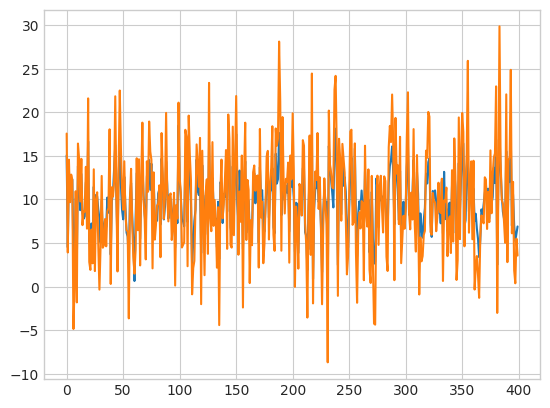

In [123]:
plt.plot(y_pred_mean)
plt.plot(y_train)

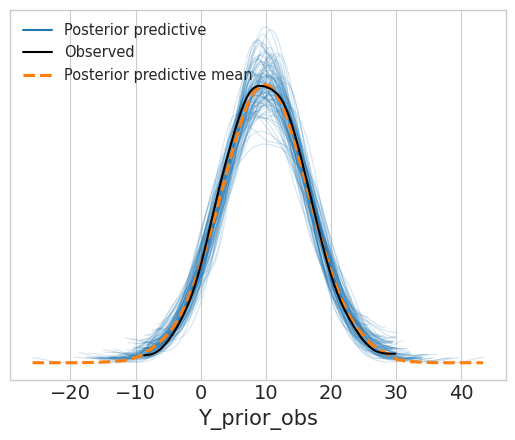

In [113]:
import arviz as az
import matplotlib.pyplot as plt
az_data = az.from_numpyro(mcmc)
az_data=az.from_numpyro(
    mcmc,
    posterior_predictive=train_predictions
)

# 5. Строим график!
az.plot_ppc(az_data, num_pp_samples=100) # num_pp_samples - сколько "поддельных" наборов данных показать
plt.show()

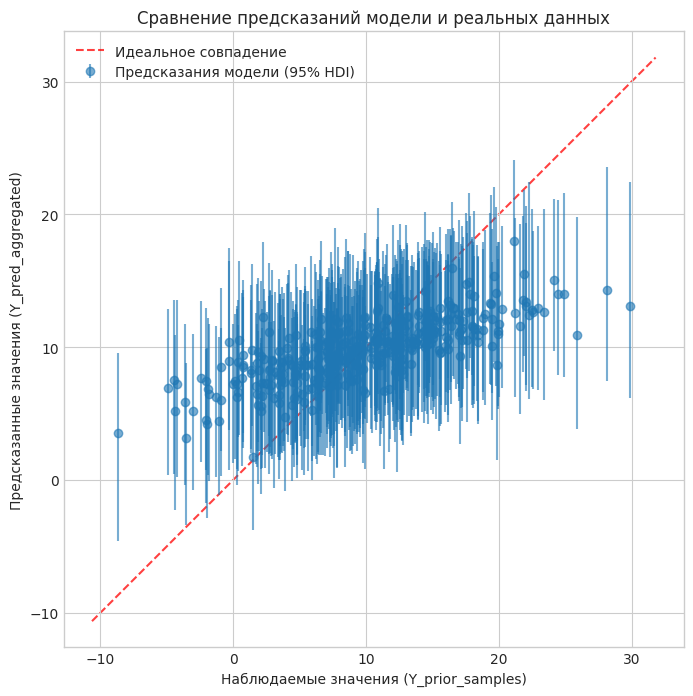

In [116]:
# Извлекаем средние предсказания и их интервалы
y_pred_mean = az_data.posterior["Y_pred_aggregated"].mean(dim=("chain", "draw")).values
hdi_data = az.hdi(az_data.posterior["Y_pred_aggregated"], hdi_prob=0.95)
y_pred_hdi = hdi_data["Y_pred_aggregated"].values

# Реальные данные
y_real = y_train

plt.figure(figsize=(8, 8))
# Строим график ошибок для каждого предсказания
# yerr - это разница между верхней/нижней границей HDI и средним
y_err = [y_pred_mean - y_pred_hdi[:, 0], y_pred_hdi[:, 1] - y_pred_mean]
plt.errorbar(y_real, y_pred_mean, yerr=y_err, fmt='o', alpha=0.6, label="Предсказания модели (95% HDI)")

# Добавляем линию y=x для идеального совпадения
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label="Идеальное совпадение")

plt.xlabel("Наблюдаемые значения (Y_prior_samples)")
plt.ylabel("Предсказанные значения (Y_pred_aggregated)")
plt.title("Сравнение предсказаний модели и реальных данных")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [157]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax.ops import segment_sum

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax.ops import segment_sum

def random_intercept_slope_model(
    X_measurements,
    sample_idx,
    n_samples,
    feature_idx_for_slope=0,
    Y_prior_samples=None
):
    n_total_measurements, n_features = X_measurements.shape
    
    alpha_global = numpyro.sample("alpha_global", dist.Normal(0.0, 10.0))
    beta_global = numpyro.sample("beta_global", dist.Normal(0, 2).expand([n_features]))

    dim_rand_effects = 2 
    
    chol_corr = numpyro.sample(
        "chol_corr", 
        dist.LKJCholesky(dimension=dim_rand_effects, concentration=1.0)
    )
    
    sigma_rand = numpyro.sample("sigma_rand", dist.HalfCauchy(2.5).expand([dim_rand_effects]))
    
    L_cov = jnp.diag(sigma_rand) @ chol_corr

    with numpyro.plate("samples_plate", n_samples):
        z = numpyro.sample(
            "z",
            dist.Normal(0, 1).expand([dim_rand_effects]).to_event(1)
        )
    
    rand_effects = z @ L_cov.T
    alpha_offset = rand_effects[:, 0]
    beta_slope_offset = rand_effects[:, 1]
    
    alpha_per_sample = numpyro.deterministic("alpha_per_sample", alpha_global + alpha_offset)
    
    beta_slope_per_sample = numpyro.deterministic(
        "beta_slope_per_sample", 
        beta_global[feature_idx_for_slope] + beta_slope_offset
    )
    
    intercept_term = alpha_per_sample[sample_idx]
    slope_term = beta_slope_per_sample[sample_idx] * X_measurements[:, feature_idx_for_slope]
    
    # Alternative approach for fixed_slopes_term that avoids boolean masking
    # Create a mask where all features are included except the slope feature
    mask = jnp.ones(n_features).at[feature_idx_for_slope].set(0)
    fixed_slopes_term = (X_measurements * mask) @ beta_global
    
    output = intercept_term + slope_term + fixed_slopes_term
    y_pred_measurements = numpyro.deterministic("y_pred_measurements", output)
    
    y_sum_per_sample = segment_sum(y_pred_measurements, sample_idx, num_segments=n_samples)
    counts_per_sample = segment_sum(jnp.ones_like(y_pred_measurements), sample_idx, num_segments=n_samples)
    counts_per_sample = jnp.maximum(counts_per_sample, 1)
    Y_pred_aggregated = numpyro.deterministic("Y_pred_aggregated", y_sum_per_sample / counts_per_sample)
    
    nu = numpyro.sample("nu", dist.Exponential(0.1))
    sigma_prior = numpyro.sample("sigma_prior", dist.HalfCauchy(5))
    
    with numpyro.plate("samples_plate_obs", n_samples):
        numpyro.sample(
            "Y_prior_obs",
            dist.StudentT(df=nu, loc=Y_pred_aggregated, scale=sigma_prior),
            obs=Y_prior_samples
        )

    corr_matrix = chol_corr @ chol_corr.T
    numpyro.deterministic("rho", corr_matrix)

In [164]:
n_samples_train = int(jnp.max(sample_idx_train)) + 1 if sample_idx_train.size > 0 else 0

# --- Запуск MCMC с новым аргументом ---
kernel = NUTS(random_intercept_slope_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(
    key, 
    X_measurements=jnp.asarray(X_train_scaled), 
    sample_idx=jnp.asarray(sample_idx_train), 
    n_samples=n_samples_train, # <<< ПЕРЕДАЕМ ВЫЧИСЛЕННОЕ ЗНАЧЕНИЕ
    feature_idx_for_slope=34,
    Y_prior_samples=jnp.asarray(y_train)
)

# Выводим сводку по апостериорным распределениям параметров
print("\n--- Результаты обучения модели (сводка по параметрам) ---")
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:42<00:00, 70.64it/s, 7 steps of size 1.78e-01. acc. prob=0.38]  



--- Результаты обучения модели (сводка по параметрам) ---

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_global      9.82      0.28      9.81      9.37     10.28    134.23      1.00
 beta_global[0]     -0.27      0.74     -0.35     -1.29      1.11    126.57      1.00
 beta_global[1]     -0.23      0.82     -0.28     -1.33      1.24     38.90      1.00
 beta_global[2]      0.12      0.94      0.10     -1.37      1.64     30.88      1.01
 beta_global[3]     -0.16      0.74     -0.20     -1.21      1.09     55.18      1.08
 beta_global[4]     -0.97      0.92     -0.91     -2.65      0.26     56.70      1.05
 beta_global[5]      1.08      0.93      1.18     -0.52      2.54     41.02      1.00
 beta_global[6]     -0.84      0.97     -0.89     -2.47      0.67     20.24      1.05
 beta_global[7]      1.00      0.81      1.09     -0.32      2.35     47.64      1.00
 beta_global[8]      0.78      0.74      0.80     -0.42      1.98     49.36     


--- Оценка на тренировочной выборке ---
Средняя абсолютная ошибка (MAE): 3.680


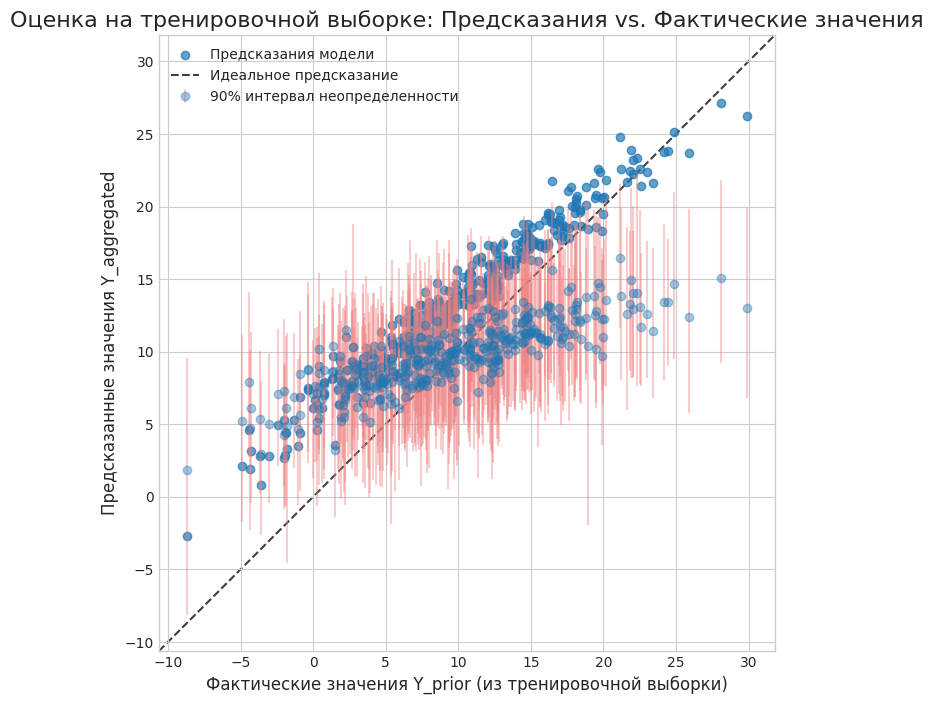

In [170]:
# --- Генерация предсказаний для тренировочной выборки ---
predictive = Predictive(random_intercept_slope_model, samples)
key, subkey = jax.random.split(key)

# --- ИСПРАВЛЕНИЕ НАЧИНАЕТСЯ ЗДЕСЬ ---

# Вычисляем недостающие параметры для тестового набора данных
n_samples_train = len(y_train) # или jnp.max(sample_idx_test) + 1
n_features_train = X_train_scaled.shape[1]

train_predictions = predictive(
    subkey, 
    X_measurements=X_train_scaled, 
    sample_idx=sample_idx_train,
    n_samples=n_samples_train,      # <--- Добавляем n_samples
    # <--- Добавляем n_features
)

# --- ИСПРАВЛЕНИЕ ЗАКАНЧИВАЕТСЯ ЗДЕСЬ ---

# Извлекаем предсказанные агрегированные значения

# Извлекаем предсказанные агрегированные значения
y_pred_mean = jnp.mean(train_predictions['Y_pred_aggregated'], axis=0)
y_pred_std = jnp.std(train_predictions['Y_pred_aggregated'], axis=0)
y_pred_corrected = apply_rotation_correction(y_train, y_pred_mean, angle_degrees=30)

# Рассчитываем 90% интервал правдоподобия
ci_lower = jnp.percentile(train_predictions['Y_pred_aggregated'], 5, axis=0)
ci_upper = jnp.percentile(train_predictions['Y_pred_aggregated'], 95, axis=0)


# --- Оценка качества ---
mae = jnp.mean(jnp.abs(y_pred_mean - y_train))
print(f"\n--- Оценка на тренировочной выборке ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")


# --- Визуализация результатов ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Диаграмма рассеяния: предсказанные vs фактические значения
ax.scatter(y_train, y_pred_corrected, alpha=0.7, label='Предсказания модели')

# Добавляем интервалы неопределенности для каждого предсказания
ax.errorbar(y_train, y_pred_mean, yerr=[y_pred_mean - ci_lower, ci_upper - y_pred_mean], 
            fmt='o', ecolor='lightcoral', capsize=0, alpha=0.4, label='90% интервал неопределенности')

# Идеальная линия y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Идеальное предсказание')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Оценка на тренировочной выборке: Предсказания vs. Фактические значения', fontsize=16)
ax.set_xlabel('Фактические значения Y_prior (из тренировочной выборки)', fontsize=12)
ax.set_ylabel('Предсказанные значения Y_aggregated', fontsize=12)
ax.legend()
plt.show()

In [166]:
import jax.numpy as jnp

def rotate_predictions(y_true, y_pred, angle_degrees):
    """
    Поворачивает точки (y_true, y_pred) на заданный угол против часовой стрелки
    """
    angle_rad = jnp.radians(angle_degrees)
    cos_angle = jnp.cos(angle_rad)
    sin_angle = jnp.sin(angle_rad)
    
    # Матрица поворота против часовой стрелки
    rotation_matrix = jnp.array([
        [cos_angle, -sin_angle],
        [sin_angle,  cos_angle]
    ])
    
    # Складываем координаты в матрицу [2, N]
    points = jnp.stack([y_true, y_pred], axis=0)
    
    # Применяем поворот
    rotated_points = rotation_matrix @ points
    
    return rotated_points[0], rotated_points[1]  # (y_true_rot, y_pred_rot)

# Пример использования после получения предсказаний
def apply_rotation_correction(y_true, y_pred, angle_degrees=6.5):
    """Применяет коррекцию поворота к предсказаниям"""
    y_true_rot, y_pred_rot = rotate_predictions(y_true, y_pred, angle_degrees)
    return y_pred_rot  # Возвращаем только исправленные предсказания

In [150]:
type(sample_idx_train)

numpy.ndarray

In [135]:
import numpyro
from numpyro.infer import MCMC, NUTS
from jax import random
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# --- Подготовка (предполагается, что эти данные у вас уже есть) ---
# rng_key = random.PRNGKey(0)
# X_measurements_data = ...
# sample_idx_data = ...
# n_samples_static = ...
# Y_prior_samples_data = ...
# n_features = X_measurements_data.shape[1]

# ВАЖНО: Выберите индекс признака для случайного наклона.
# Например, если вы считаете, что самый важный признак - первый, используйте 0.
# Для примера, мы возьмем первый признак (индекс 0).
FEATURE_FOR_SLOPE = 8

# 1. Создаем ядро NUTS
kernel = NUTS(random_intercept_slope_model)

# 2. Создаем объект MCMC
mcmc_slope = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,
)

# 3. Запускаем сэмплинг!
#rng_key, _ = random.split(rng_key)
mcmc_slope.run(
    key,
    X_measurements=X_train_scaled,
    sample_idx=sample_idx_train,
    n_samples=n_samples_train,
    feature_idx_for_slope=FEATURE_FOR_SLOPE, # <-- Передаем новый параметр
    Y_prior_samples=y_train,
)

# 4. Выводим сводку
print("Сводка для модели со случайными наклонами:")
mcmc_slope.print_summary()

# 5. Конвертируем в объект ArviZ для визуализации
az_data_slope = az.from_numpyro(mcmc_slope)

TypeError: LKJCholesky.__init__() got an unexpected keyword argument 'eta'